<a href="https://colab.research.google.com/github/oluwamayowaa/twitter-sentiment-analysis/blob/main/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install tweepy
!pip install wordcloud
! pip install requests
!pip install geopy
!pip install geocoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 34.9 MB/s 
     |████████████████████████████████| 163 kB 65.8 MB/s 
     |████████████████████████████████| 7.6 MB 51.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 98 kB 8.0 MB/s 


## Imports

In [ ]:
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import torch
import requests
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from geopy.geocoders import Nominatim

## API Credentials

Authenticating the tweepy API with personal consumer key and secret.

In [ ]:
# Handling authentication with twitter via OAuthHandler

auth = OAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth, wait_on_rate_limit= True)

In [ ]:
# Search keyword
keyword = '@Airbnb'
# Filtering the keyword to remove retweets
keyword = keyword + '-filter:retweets'

In [ ]:
# number of tweets we are requesting for
max_tweets = 5000
# date_since = '2022-01-01' # we would be choosing tweets from 2022/01/01

In [ ]:
# Creating a cursor object to scrap tweets using the twitter API

tweets = tweepy.Cursor(api.search,
                       q= keyword, lang = 'en',
                       tweet_mode = 'extended',
                       result_type = 'recent').items(max_tweets)

In [ ]:
# Creating a list of tweets, handles, user locations and verification status

tweet_list = [[tweet.user.screen_name, tweet.full_text, tweet.user.location, tweet.coordinates] for tweet in tweets]

In [ ]:
# Converting tweets into a dataframe

df = pd.DataFrame(data = tweet_list, columns = ['user', 'tweet', 'location', 'coordinates'])

In [ ]:
# Saving the dataframe as a CSV file:

df.to_csv('airbnb.csv')

### Exploring the dataset

In [ ]:
air_df = df.copy()
air_df.head()

,user,tweet,location,coordinates
0,abhimanyuskarma,@Airbnb you suck big time ! I had to cancel my...,,None
1,analydiamonaco,"Folks, does anyone have a first floor @airbnb...","Westdale / Culver City, CA",None
2,CashhChristine,@AirbnbHelp Why @airbnb @airbnbhelp don't care...,,None
3,JoycNicholson,@AirbnbHelp Why @airbnb @airbnbhelp don't care...,,None
4,CurtisCrimmins,@BergTheDip I started @RoomzaHotels for folks ...,,None


In [ ]:
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3610 entries, 0 to 3609
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user         3610 non-null   object
 1   tweet        3610 non-null   object
 2   location     3610 non-null   object
 3   coordinates  0 non-null      object
dtypes: object(4)
memory usage: 112.9+ KB


The coordinates column is empty, so it's going to get dropped.

### Checking Duplicates

Checking for duplicate tweets in the dataset

In [ ]:
air_df.duplicated().sum()

9

There are 9 duplicate samples in the dataframe.

In [ ]:
air_df[air_df.duplicated()]

,user,tweet,location,coordinates
13,Roman_Sooshko,@Airbnb Hey AirBnb whats wrong with you I just...,,None
670,DwayneTriplett1,@Airbnb Hey how are you? @Airbnb,,None
2096,MK_ULTA_,@chaoaretasty @Naara_of_Themis @BirdRespecter ...,,None
2912,TexasCritic,.@AirBnB has been caught removing honest and d...,San Antonio,None
3237,IM_GATI,@bookingcom Regarding reservations in Morros c...,,None
3238,IM_GATI,@bookingcom Regarding reservations in Morros c...,,None
3550,IM_GATI,@bookingcom Regarding reservations in Morros c...,,None
3551,IM_GATI,@bookingcom Regarding reservations in Morros c...,,None
3553,IM_GATI,@bookingcom Regarding reservations in Morros c...,,None


Dropping duplicates

In [ ]:
air_df.drop_duplicates(inplace = True)

### Checking for missing values in the dataset

In [ ]:
air_df.isna().sum()

user              0
tweet             0
location          0
coordinates    3601
dtype: int64

The only null values in the dataset are in the coordinates column

In [ ]:
air_df.drop(columns = ['coordinates'], inplace = True)

In [ ]:
import re
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [ ]:
# Creating a function to clean the tweets

def clean_tweet(tweet):
    tweet = tweet.lower() # makes all characters in tweets to be lowercase
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    tweet = re.sub(" ' ", '', tweet) # remove contractions
    tweet = re.sub('@[A-Za-z0-9]+', '', tweet) # removes mentions
    tweet = re.sub('#[A-Za-z0-9]+', '', tweet) # removes all hashtags
    tweet = re.sub('http\S+', '', tweet) # removes all hyperlinks
    tweet = re.sub('[()!?]', ' ', tweet)
    tweet = re.sub('\[.*?\]',' ', tweet)
    tweet = re.sub("[^a-z0-9]"," ", tweet)
    tweet = re.sub('\n', '', tweet)
    tweet = emoji_pattern.sub('', tweet) # Removing emoji patterns
    return tweet

air_df['clean_tweet'] = air_df['tweet'].apply(clean_tweet)

In [ ]:
air_df.head()

,user,tweet,location,clean_tweet
0,abhimanyuskarma,@Airbnb you suck big time ! I had to cancel my...,,you suck big time i had to cancel my bookin...
1,analydiamonaco,"Folks, does anyone have a first floor @airbnb...","Westdale / Culver City, CA",folks does anyone have a first floor in the...
2,CashhChristine,@AirbnbHelp Why @airbnb @airbnbhelp don't care...,,why don t care about super host
3,JoycNicholson,@AirbnbHelp Why @airbnb @airbnbhelp don't care...,,why don t care about super host
4,CurtisCrimmins,@BergTheDip I started @RoomzaHotels for folks ...,,i started for folks like you and you ve got ...


### Loading model and tokenizer from the hugging face hub

In [ ]:
# importing tokenizer and transformers from the hugging face hub

from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = 'cardiffnlp/twitter-roberta-base-sentiment-latest'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from scipy.special import softmax

In [ ]:
def sentiment_score(tweet):
    tokens = tokenizer.encode(tweet, padding = True, return_tensors = 'pt')
    output = model(tokens)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return np.argmax(scores)

In [ ]:
air_df['sentiment_score'] = air_df['clean_tweet'].apply(sentiment_score)

In [ ]:
def sentiment(score):
    if score == 0:
        return 'Negative'
    elif score == 1:
        return 'Neutral'
    elif score == 2:
        return 'Positive'

In [ ]:
air_df['sentiment'] = air_df['sentiment_score'].apply(sentiment)

In [ ]:
air_df.head()

,user,tweet,location,clean_tweet,sentiment_score,sentiment
0,abhimanyuskarma,@Airbnb you suck big time ! I had to cancel my...,,you suck big time i had to cancel my bookin...,0,Negative
1,analydiamonaco,"Folks, does anyone have a first floor @airbnb...","Westdale / Culver City, CA",folks does anyone have a first floor in the...,1,Neutral
2,CashhChristine,@AirbnbHelp Why @airbnb @airbnbhelp don't care...,,why don t care about super host,0,Negative
3,JoycNicholson,@AirbnbHelp Why @airbnb @airbnbhelp don't care...,,why don t care about super host,0,Negative
4,CurtisCrimmins,@BergTheDip I started @RoomzaHotels for folks ...,,i started for folks like you and you ve got ...,1,Neutral


In [ ]:
sentiment_count = air_df.groupby(['sentiment']).size()
print(sentiment_count)

sentiment
Negative    1887
Neutral     1273
Positive     441
dtype: int64


Tweets mentioning the AirBNB official account are mostly negative, with only 441 being positive.

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
fig = go.Figure(data = [go.Pie(labels = sentiment_count.index, values = sentiment_count.values, hole = .5)])
fig.show()

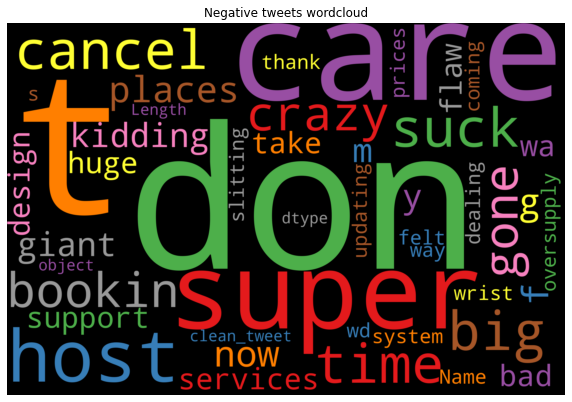

In [ ]:
# Wordcloud of negative tweets

negative_tweets = air_df['clean_tweet'][air_df['sentiment'] == 'Negative']
stop_words = list(STOPWORDS)
negative_wordcloud = WordCloud(width = 3000,
                               height= 2000,
                               background_color = 'black', 
                               colormap = 'Set1',
                               stopwords = stop_words).generate(str(negative_tweets))

plt.figure(figsize = [10, 10])
plt.title('Negative tweets wordcloud')
plt.imshow(negative_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

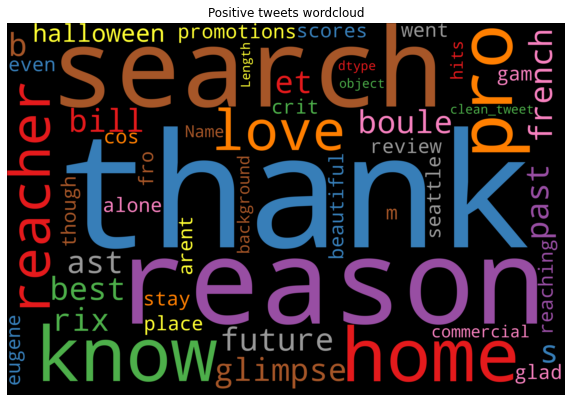

In [ ]:
# Wordcloud of positive tweets

positive_tweets = air_df['clean_tweet'][air_df['sentiment'] == 'Positive']
stop_words = list(STOPWORDS)
positive_wordcloud = WordCloud(width = 3000,
                               height = 2000,
                               background_color = 'black',
                               colormap = 'Set1',
                               stopwords = stop_words).generate(str(positive_tweets))

plt.figure(figsize = [10, 10])
plt.title('Positive tweets wordcloud')
plt.imshow(positive_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()